In [1]:
#import libraries
import numpy as np
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats

#allows Jupyter to render graphs inline
%matplotlib inline

In [2]:
'''
Node class represents a single point in the TSP graph
name: node number
x: x coordinate
y: y coordinate
'''
class Node:
    #Constructor for the class
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y
     
    '''
    Computes the euclidean distance between this node and a given node
    Input: Node object
    Output: float distance
    '''
    def distance(self, node):
        return math.sqrt((self.x-node.x)**2 + (self.y-node.y)**2)

'''
Individual class represents a path and is a member of the population
path: list of nodes
distance: overall path length
fitness: 1/distance
'''    
class Individual:
    #Constructor
    def __init__(self, path):
        self.path = path
        self.distance = 0.0
        self.fitness = 0.0
    
    '''
    Computes the path length of the individual
    Input: None
    Output: float path_length
    '''
    def path_length(self):
        pl = 0
        for i in range(0, len(self.path)):
            node1 = self.path[i]
            node2 = None
            if i+1 < len(self.path):
                node2 = self.path[i+1]
            else:
                node2 = self.path[0]
            pl = pl + node1.distance(node2)
            self.distance = pl
            self.fitness = 1/float(pl)
        return pl
    
    '''
    Returns the object's path as a list of strings
    Input: None
    Output: list path
    '''
    def get_path(self):
        path_list = []
        for i in self.path:
            path_list.append(i.name)
        return path_list

'''
Creates the first population by random selection of paths
Input: int population_size, list collection_of_nodes
Output: list collection_of_individuals
'''
def initialize_pop(pop_size, nodes):
    population = []
    for i in range(0, pop_size):
        route = random.sample(nodes, len(nodes))
        individual = Individual(route)
        population.append(individual)
    return population

'''
Reads in a .tsp file and creates the collection of Nodes
Input: string file_name
Output: list collection_of_nodes
'''
def read_tsp(file_name):
    nodes = []
    with open(file_name, "r") as file:
        data = file.readlines()
        
    for i in data:
        split_i = i.split(" ")
        if len(split_i) == 3:
            nodes.append(Node(int(split_i[0]), float(split_i[1]), float(split_i[2])))
    return nodes

'''
Computes the fitness values for a population within each individual
Input: list population_of_individuals
Output: None
'''
def find_fitnesses(population):
    for i in range(0, len(population)):
        population[i].path_length()

'''
Performs an elite ranking of the popluation.  The population is sorted based on fitness and 
the top gen_size is returned as a mating pool
Input: list population_of_individuals, int gen_size
Output: list sorted_and_filtered_population
'''
def rank_population_elite(population, gen_size):
    sorted_pop = sorted(population, key=lambda x: x.fitness, reverse=True)
    return sorted_pop[:gen_size]
    
    
'''
Ranks the population and selects individuals for futher ranking based on a probability
scaled based on each individual's fitness score
Input: list population_of_individuals, int gen_size
Output: list ranked_population_of_individuals
'''    
def rank_population_proportional(population, gen_size):
    selected = []
    pop_list = []
    for i in range(0, len(population)):
        pop_list.append((i, population[i].fitness))
        
    df = pd.DataFrame(pop_list, columns=["Individual", "Fitness"])
    df['breeding_chance'] = df.Fitness/df.Fitness.sum()
    for i in range(0, gen_size):
        selection = random.uniform(0,1)
        j = 0
        while True:
            row = df.iloc[j]
            selection -= row['breeding_chance']
            if selection < 0:
                break
            j+=1
        selected_row = df.iloc[j]
        selected.append(int(selected_row['Individual']))
        selected_prob = selected_row['breeding_chance']
        df = df.drop(j)
        df = df.reset_index(drop=True)
        if len(df) > 0:
            df["breeding_chance"] += selected_prob/len(df)
        
    return [population[i] for i in selected]

'''
Helper function that breeds two parents using one-point crossover
Input: Individual parent1, Individual parent2, list collection_of_nodes
Output: Individual child
'''
def breed(parent1, parent2, nodes):
    
    p1_path = parent1.get_path()
    p2_path = parent2.get_path()
    
    gene1 = int(random.random()*len(p1_path))
    gene2 = int(random.random()*len(p1_path))
    
    start_idx = min(gene1, gene2)
    end_idx = max(gene1, gene2)
    
    segment_p1 = p1_path[start_idx:end_idx]
    segment_p2 = [i for i in p2_path if i not in segment_p1]
    
    new_path = segment_p1 + segment_p2
    child_path = []
    
    for i in new_path:
        for j in nodes:
            if j.name == i:
                child_path.append(Node(i, j.x, j.y))
    
    
    child = Individual(child_path)
    
    return Individual(child_path)

'''
Uses the breed() function to breed random pairs of individuals within a population
Input: list pool_of_parents, list collection_of_nodes
Output: list next_generation
'''
def breed_pop(pool, size, nodes):
    children = []
    
    for i in pool:
        children.append(i)
    
    while len(children) != size:
        parents = random.sample(pool, 2)
        child = breed(parents[0], parents[1], nodes)
        children.append(child)
        
    return children

'''
Performs an in-place swap mutation in an individual
Input: Individual i
Output: None
'''
def mutate(individual):
    num_nodes = len(individual.path)
    idx1 = int(random.random()*num_nodes)
    idx2 = int(random.random()*num_nodes) 
    individual.path[idx1], individual.path[idx2] = individual.path[idx2], individual.path[idx1]

'''
Rolls for whether an individual should be mutate based on the mut_rate.  If 
the random roll is smaller, then individual is mutated.  This function is performed across
the population
Input: list population_of_individuals, float mut_rate
Output: None
'''
def mutate_population(population, mut_rate):
    for i in population:
        chance = random.random()
        if chance <= mut_rate:
            mutate(i)

'''
Collection of previous methods to make a new generation.  It takes a population,
selects the mating pool, breeds them, and performs mutations across that generation
Input: list current_generation, float mut_rate, int desired_population_size,
    int ranked_selection_size, object method_of_selection, list collection_of_nodes
Output: list new_generation_of_individuals
'''
def make_generation(curr_gen, mut_rate, pop_size, select_size, selection_method, nodes):
    pop_to_breed = selection_method(curr_gen, select_size)
    new_generation = breed_pop(pop_to_breed, pop_size, nodes)
    mutate_population(new_generation, mut_rate)
    return new_generation

'''
Runs make_generation() for num_generations and records the results
Input: list collection_of_nodes, int, number_of_generations, float mut_rate, int desired_population_size,
    int ranked_selection_size, object method_of_selection
Output: float best_distance, list best_path
'''
def run_ga_tsp(nodes, num_generations, mut_rate, pop_size, select_size, selection_method):
    start_time = time.time()
    avg_gen_fit_list = []
    best_gen_fit_list = []
    
    pop = initialize_pop(pop_size, nodes)
    find_fitnesses(pop)
    
    best_fit = 0
    best_path = 0
    best_dist = math.inf
    
    for i in range(0, num_generations):
        pop = make_generation(pop, mut_rate, pop_size, select_size, selection_method, nodes)
        find_fitnesses(pop)
        
        best_gen_fit = 0
        sum_gen_fit = 0
        for j in pop:
            if j.fitness > best_gen_fit:
                best_gen_fit = j.fitness
            if best_gen_fit > best_fit:
                best_fit = best_gen_fit
                best_path = j.get_path()
            if j.distance < best_dist:
                best_dist = j.distance
            sum_gen_fit += j.fitness
        avg_gen_fit = sum_gen_fit/len(pop)
        best_gen_fit_list.append(best_gen_fit)
        avg_gen_fit_list.append(avg_gen_fit)
        
    print("Execution time: " + str(time.time()-start_time))
    
    fig, ax = plt.subplots(2, figsize=(12,12))
    ax[0].plot(range(1, len(avg_gen_fit_list)+1), avg_gen_fit_list)
    ax[0].set_title("Average Fitness by Generation")
    ax[1].plot(range(1, len(best_gen_fit_list)+1), best_gen_fit_list)
    ax[1].set_title("Best Fitness by Generation")
    
    fig.text(0.5, 0.04, "Generation", ha="center")
    fig.text(0.04, 0.5, "Fitness Scores", va="center", rotation=90)
    
    print("Best Overall Fitness: " + str(best_fit))
    print("Best Path: " + str(best_path))
    print("Best Overall Distance: " + str(best_dist))
    
    return (best_dist, best_path)

# Test 1 - Control

Execution time: 29.329766750335693
Best Overall Fitness: 0.0005811659982675424
Best Path: [78, 67, 45, 32, 63, 22, 27, 9, 44, 82, 80, 58, 57, 5, 42, 26, 77, 50, 14, 87, 49, 47, 18, 99, 69, 16, 75, 3, 86, 55, 88, 65, 48, 2, 76, 12, 11, 46, 61, 19, 91, 28, 17, 70, 90, 8, 54, 51, 29, 97, 56, 60, 98, 25, 68, 71, 34, 52, 100, 96, 23, 93, 10, 74, 41, 43, 79, 92, 15, 1, 7, 24, 94, 83, 72, 85, 21, 53, 39, 66, 73, 30, 36, 89, 37, 38, 81, 20, 95, 6, 13, 40, 31, 64, 84, 59, 33, 35, 4, 62]
Best Overall Distance: 1720.6787784918645
Execution time: 30.04711127281189
Best Overall Fitness: 0.0006681222092535851
Best Path: [10, 90, 8, 54, 97, 13, 51, 56, 29, 31, 59, 84, 25, 40, 60, 6, 20, 98, 81, 68, 15, 95, 79, 11, 69, 18, 35, 76, 64, 33, 4, 12, 47, 49, 65, 34, 86, 66, 36, 37, 38, 71, 1, 92, 43, 30, 24, 73, 72, 85, 7, 89, 75, 39, 23, 63, 52, 88, 22, 48, 26, 87, 14, 58, 80, 27, 82, 78, 45, 91, 61, 55, 28, 96, 44, 57, 5, 42, 62, 2, 50, 77, 9, 67, 100, 32, 46, 19, 41, 3, 21, 53, 17, 74, 93, 99, 16, 70, 9

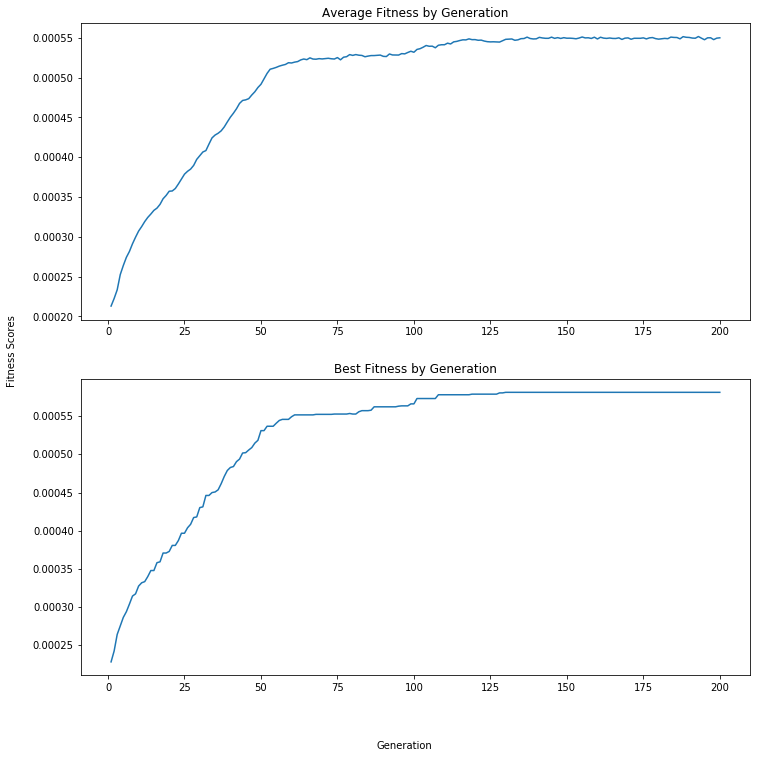

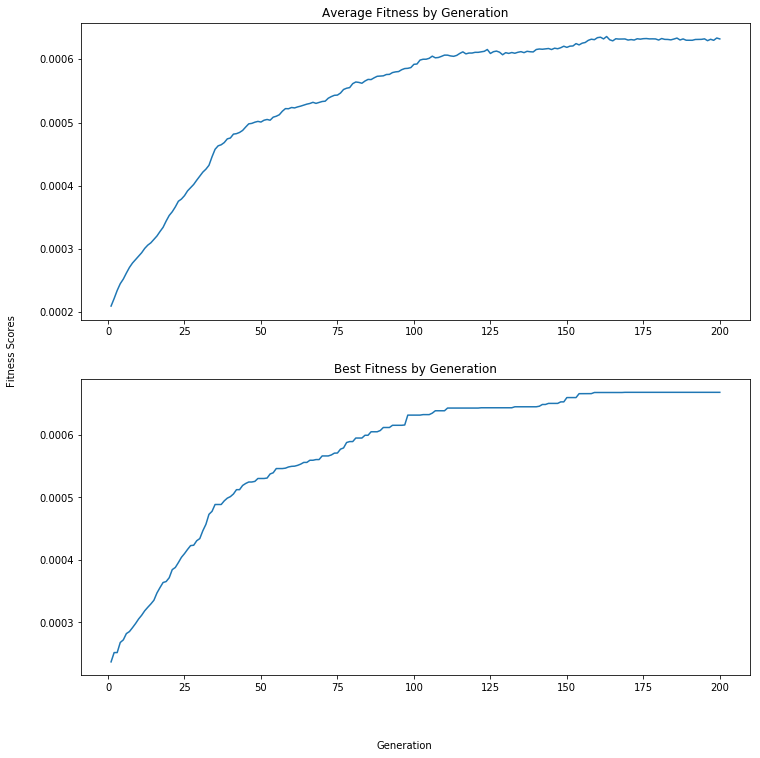

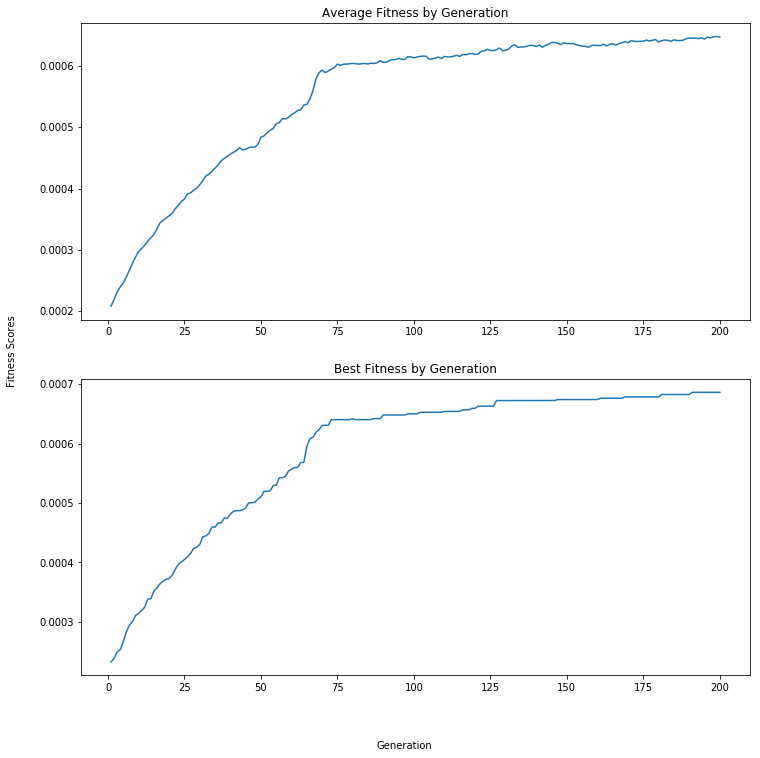

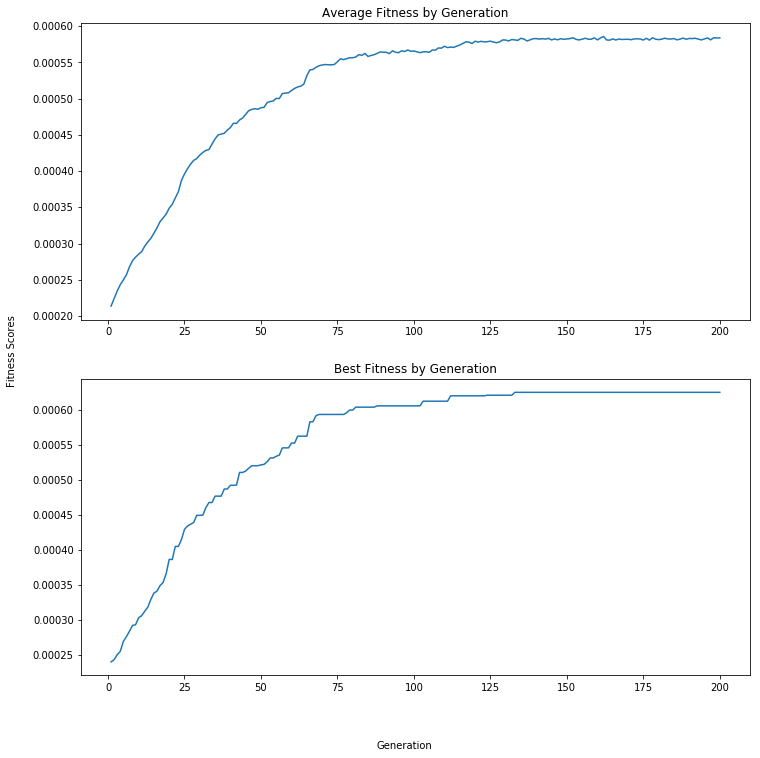

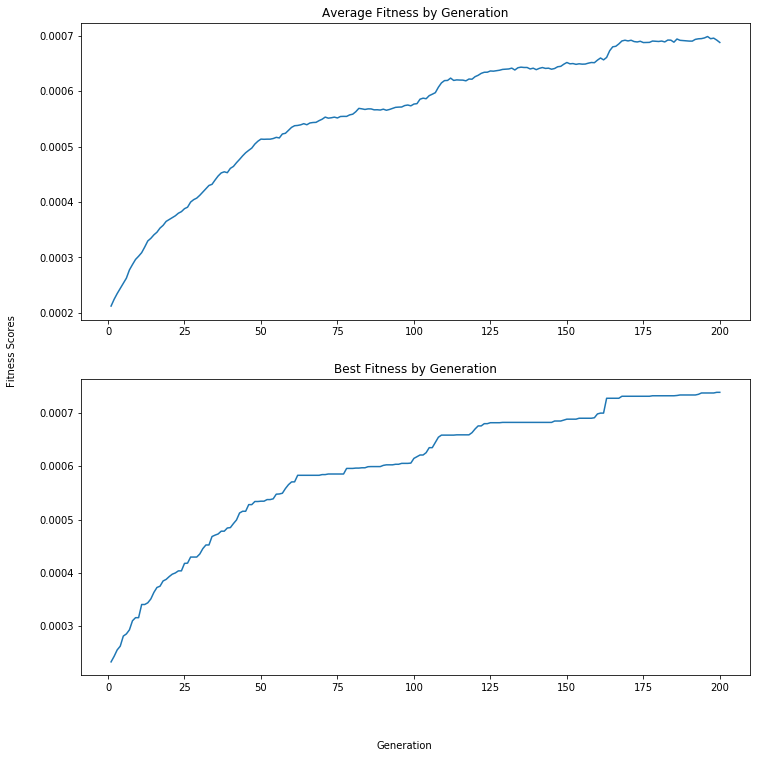

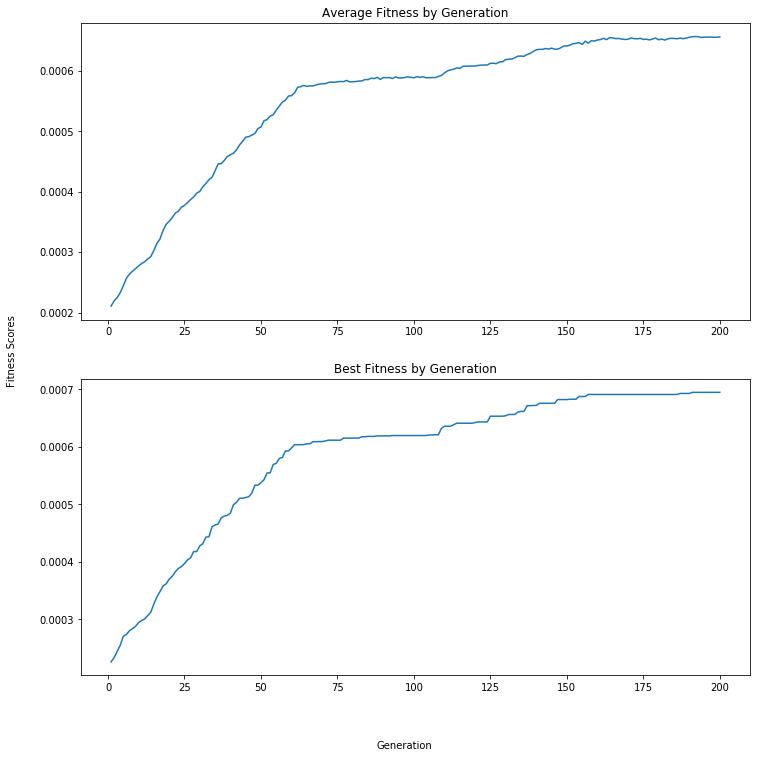

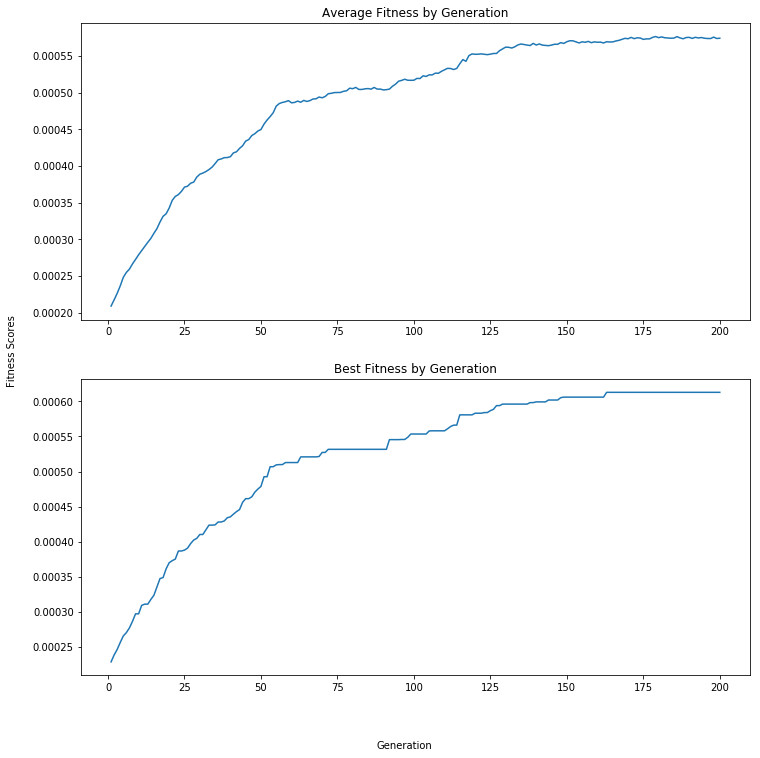

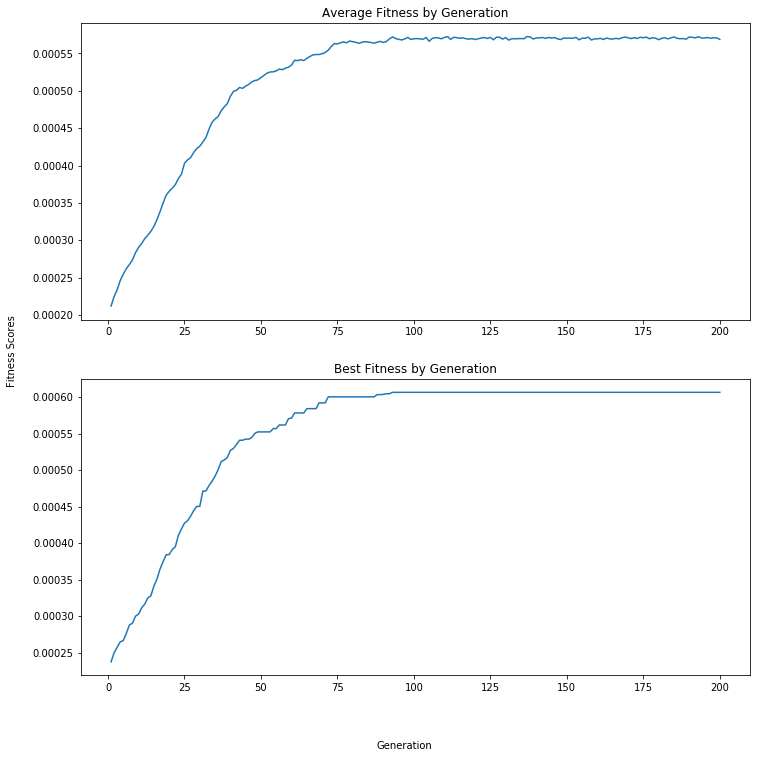

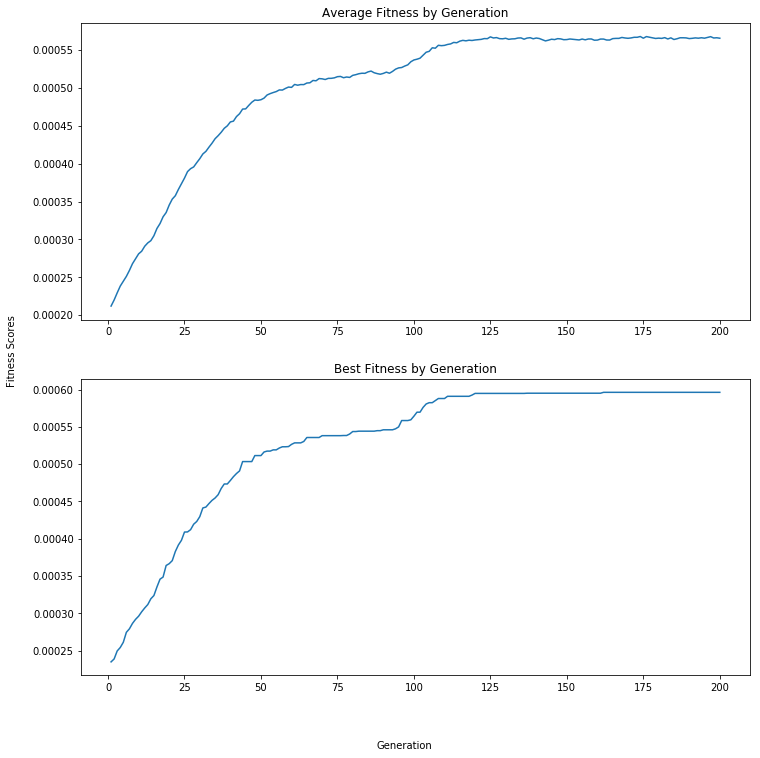

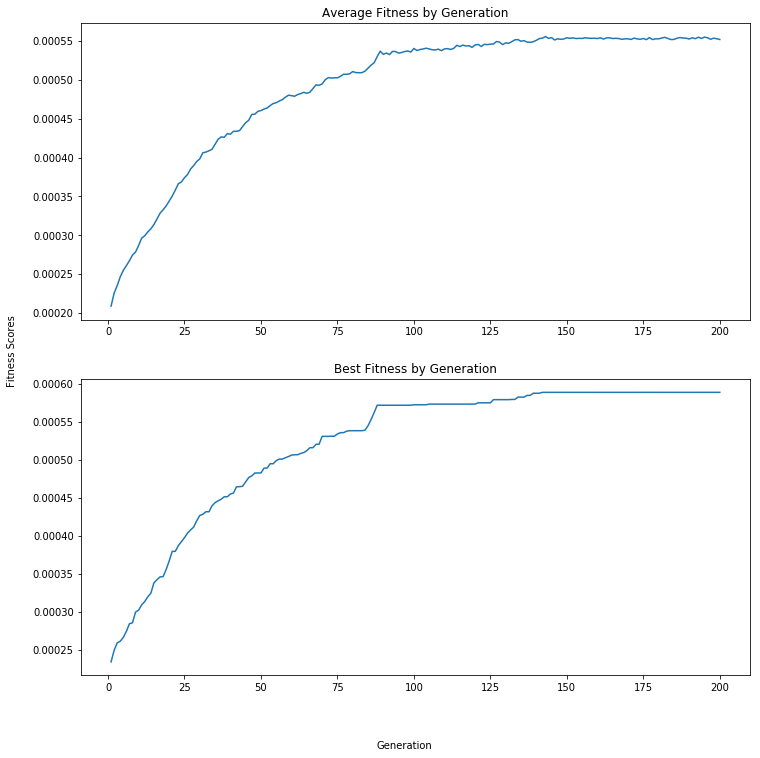

In [3]:
#Read in tsp file
nodes = read_tsp("Random100.tsp")

dists = []
times = []
best_dist = math.inf
best_path = None

#Run ga algorithm 10 times
for i in range(0,10):
    start_time = time.time()
    dist, path = run_ga_tsp(nodes, 200, 0.01, 200, 10, rank_population_elite)
    run_time = time.time()-start_time
    times.append(run_time)
    dists.append(dist)
    if dist < best_dist:
        best_dist = dist
        best_path = path
        
        
print("Best Path: ")
print(best_path)
print("Distance Statistics: ")
print(stats.describe(dists))
print("Time Statistics: ")
print(stats.describe(times))

# Test 2 - Lower Population Size

Execution time: 7.8588783740997314
Best Overall Fitness: 0.0005526787097720735
Best Path: [98, 60, 6, 20, 40, 25, 84, 33, 31, 4, 87, 49, 69, 2, 22, 67, 78, 77, 50, 26, 11, 47, 59, 35, 97, 18, 16, 90, 10, 70, 93, 3, 53, 21, 37, 39, 17, 41, 71, 1, 66, 75, 7, 72, 30, 68, 95, 43, 92, 85, 73, 24, 94, 99, 12, 57, 82, 64, 13, 29, 51, 56, 54, 8, 34, 86, 48, 96, 46, 61, 63, 52, 32, 100, 76, 58, 62, 42, 80, 44, 88, 55, 28, 27, 9, 5, 14, 65, 45, 19, 23, 91, 38, 74, 36, 89, 83, 15, 79, 81]
Best Overall Distance: 1809.3694986231753
Execution time: 7.587110757827759
Best Overall Fitness: 0.000577425936813538
Best Path: [31, 84, 64, 62, 78, 9, 27, 58, 50, 88, 22, 55, 48, 76, 14, 26, 82, 5, 44, 80, 57, 42, 67, 100, 52, 65, 61, 32, 45, 63, 96, 19, 91, 66, 68, 92, 79, 95, 1, 83, 94, 75, 21, 93, 7, 73, 85, 81, 20, 60, 6, 98, 72, 17, 74, 99, 16, 70, 90, 10, 37, 39, 36, 24, 15, 43, 89, 71, 30, 38, 23, 28, 86, 53, 41, 3, 34, 46, 49, 35, 4, 59, 33, 97, 87, 77, 2, 69, 18, 47, 12, 11, 8, 54, 51, 40, 25, 13, 56

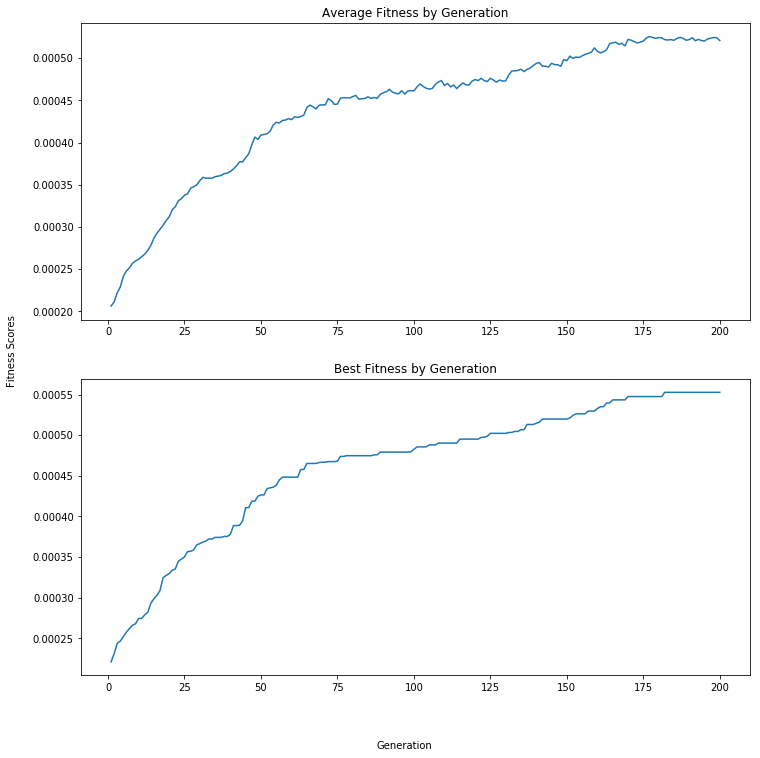

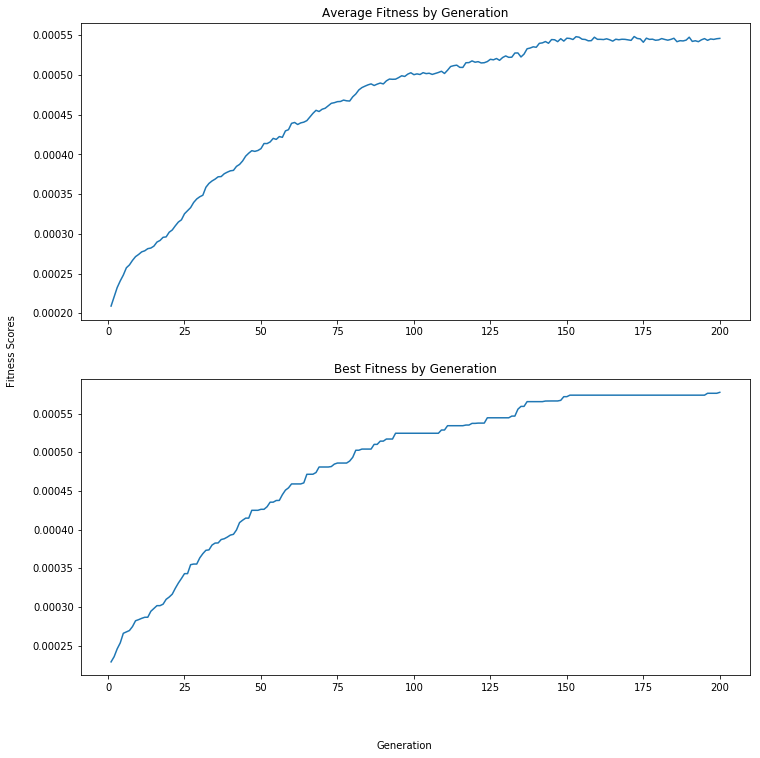

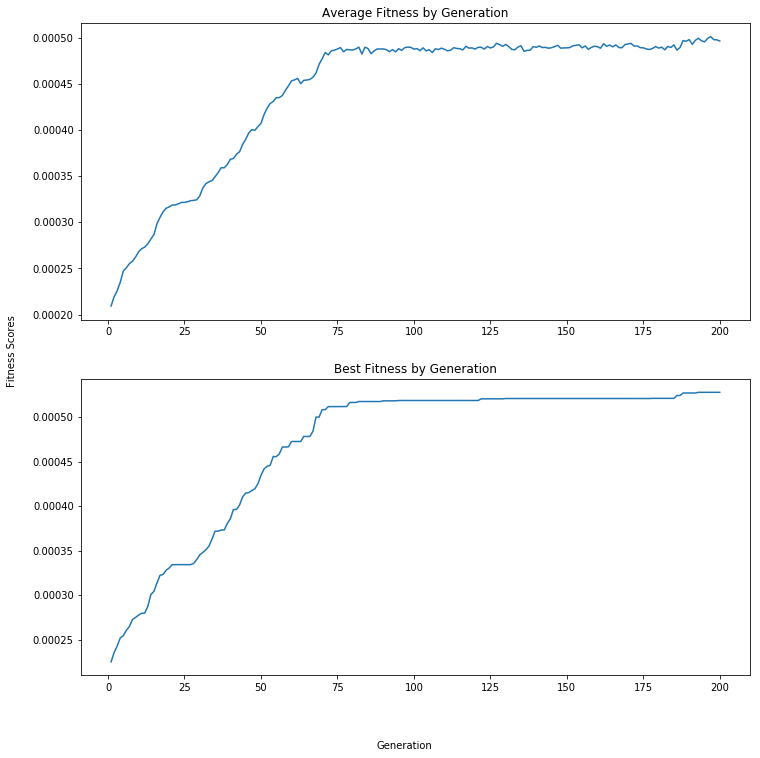

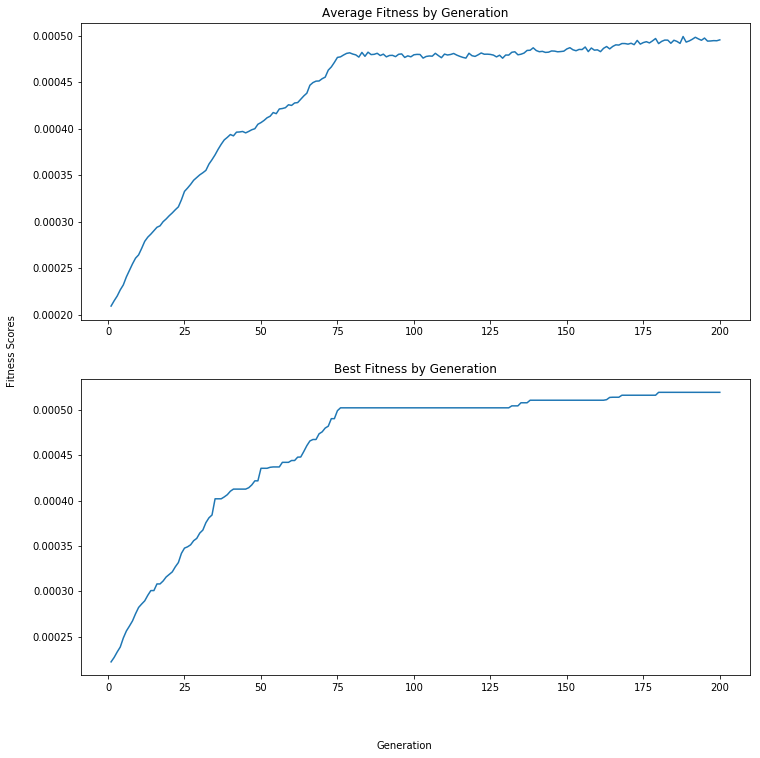

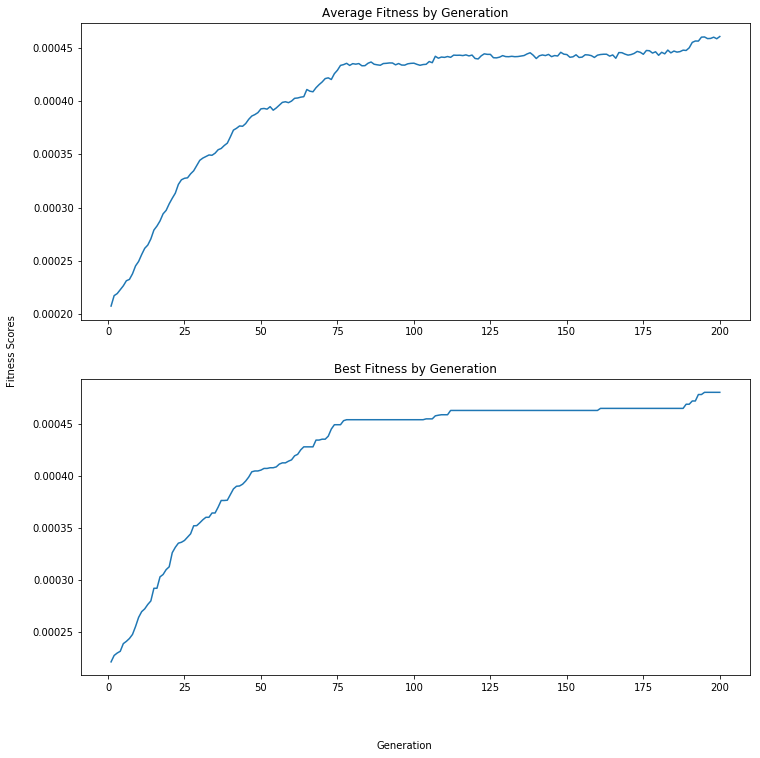

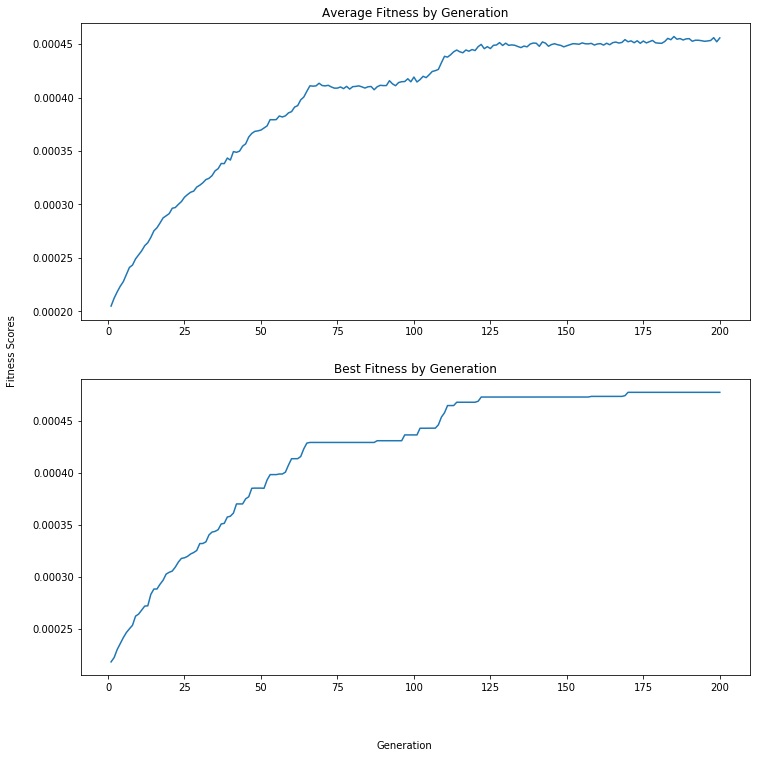

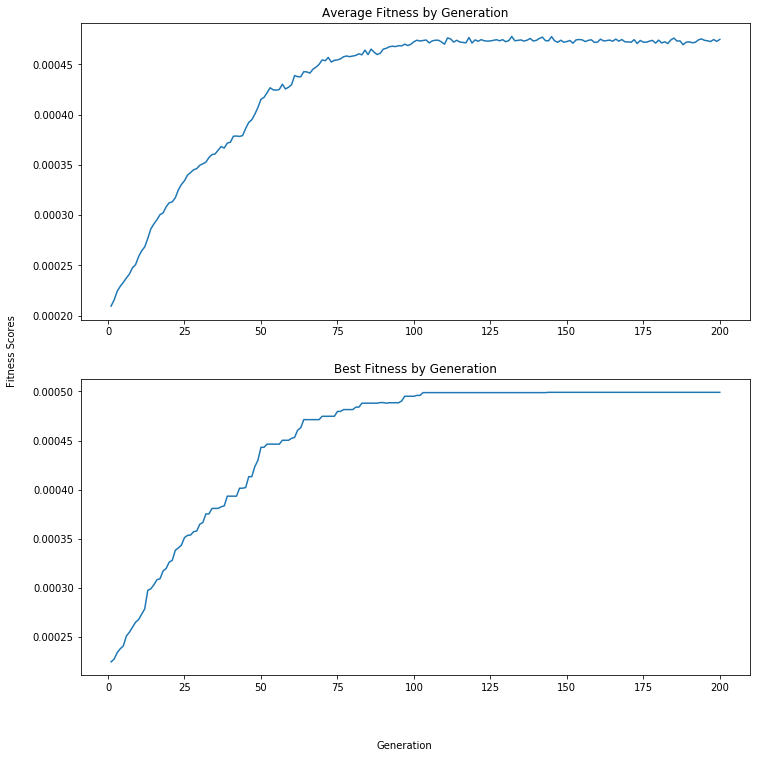

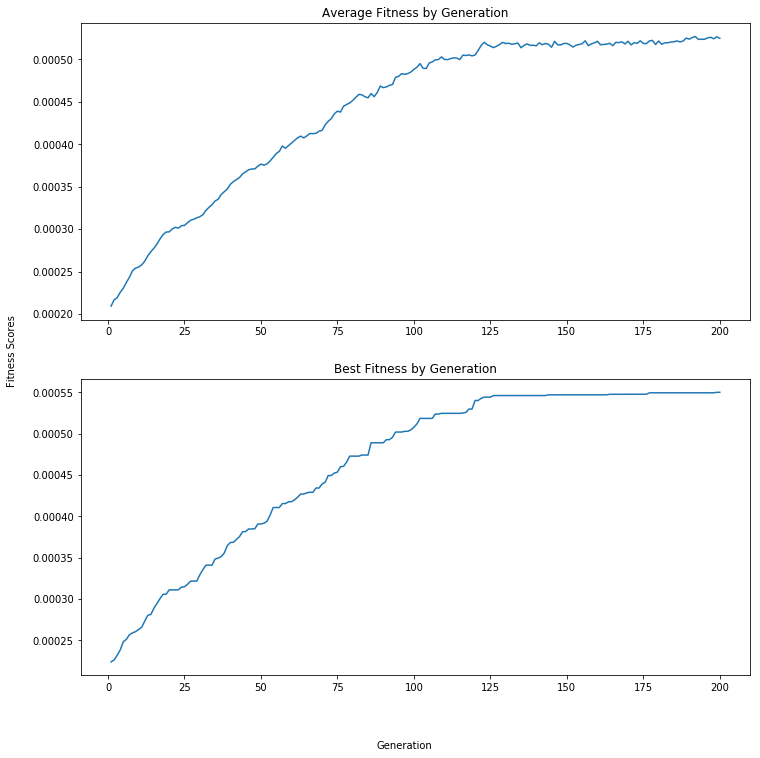

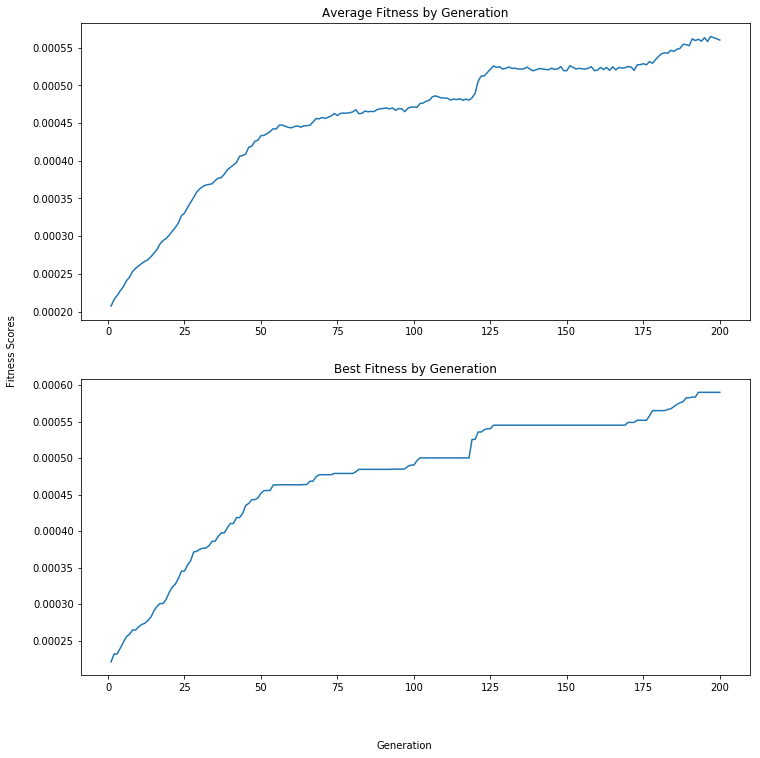

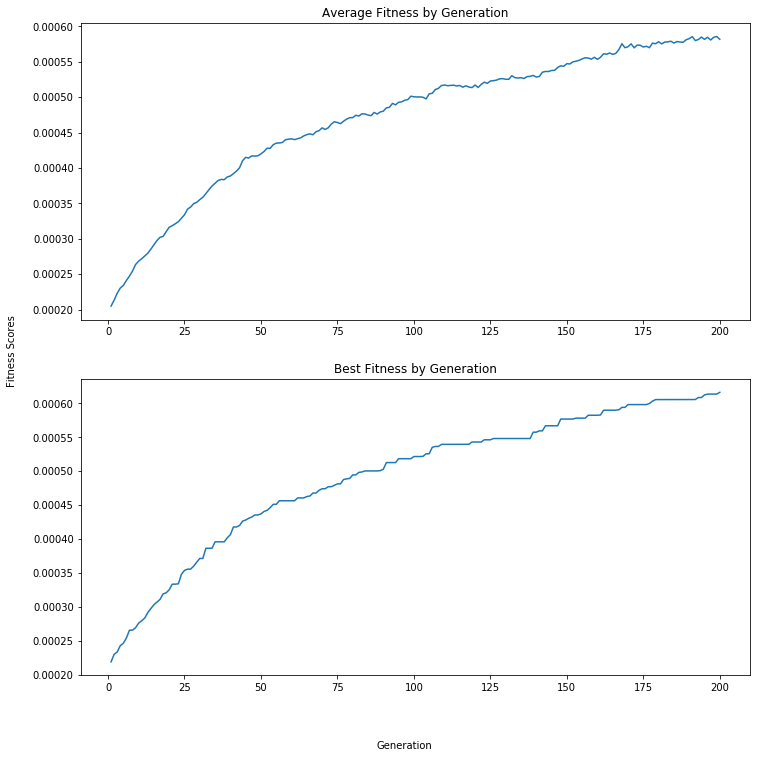

In [4]:
#Read in tsp file
nodes = read_tsp("Random100.tsp")

dists = []
times = []
best_dist = math.inf
best_path = None

#Run ga algorithm 10 times
for i in range(0,10):
    start_time = time.time()
    dist, path = run_ga_tsp(nodes, 200, 0.01, 50, 5, rank_population_elite)
    run_time = time.time()-start_time
    times.append(run_time)
    dists.append(dist)
    if dist < best_dist:
        best_dist = dist
        best_path = path
        
        
print("Best Path: ")
print(best_path)
print("Distance Statistics: ")
print(stats.describe(dists))
print("Time Statistics: ")
print(stats.describe(times))

# Test 3 - Proportional Ranking

Execution time: 60.59106779098511
Best Overall Fitness: 0.00022680253880713464
Best Path: [55, 47, 19, 33, 11, 83, 16, 15, 27, 99, 17, 35, 56, 6, 58, 64, 42, 76, 78, 50, 72, 89, 46, 91, 31, 86, 40, 84, 81, 95, 90, 87, 79, 85, 68, 71, 26, 59, 65, 88, 61, 75, 100, 82, 14, 62, 45, 70, 92, 51, 36, 32, 67, 18, 77, 8, 53, 9, 52, 2, 24, 73, 38, 43, 98, 57, 80, 93, 39, 54, 25, 5, 34, 49, 1, 3, 48, 21, 23, 12, 97, 7, 41, 13, 29, 44, 4, 22, 30, 74, 63, 28, 96, 20, 69, 94, 37, 66, 60, 10]
Best Overall Distance: 4409.121719974955
Execution time: 62.38408660888672
Best Overall Fitness: 0.00024431420958880555
Best Path: [100, 34, 32, 71, 19, 7, 73, 39, 36, 40, 8, 93, 63, 53, 28, 70, 75, 89, 14, 91, 96, 56, 9, 82, 58, 1, 2, 76, 3, 80, 74, 72, 52, 46, 60, 81, 11, 41, 95, 92, 21, 37, 27, 24, 85, 4, 90, 65, 25, 79, 15, 94, 18, 20, 98, 17, 6, 10, 57, 67, 44, 42, 31, 22, 38, 13, 78, 84, 68, 43, 30, 29, 87, 54, 50, 77, 33, 62, 23, 88, 16, 97, 12, 51, 64, 26, 35, 48, 49, 86, 66, 45, 5, 59, 47, 99, 83, 61, 5

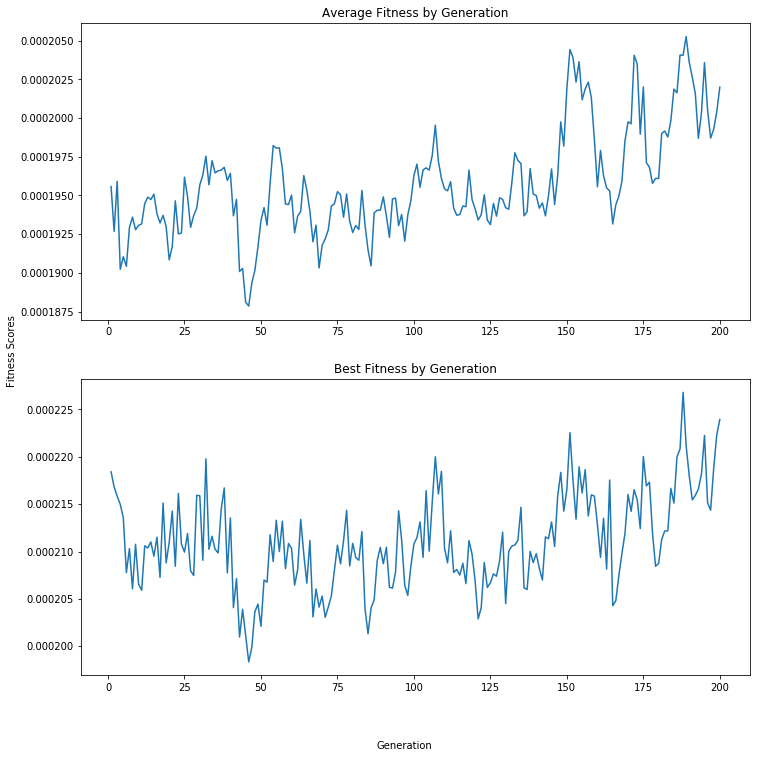

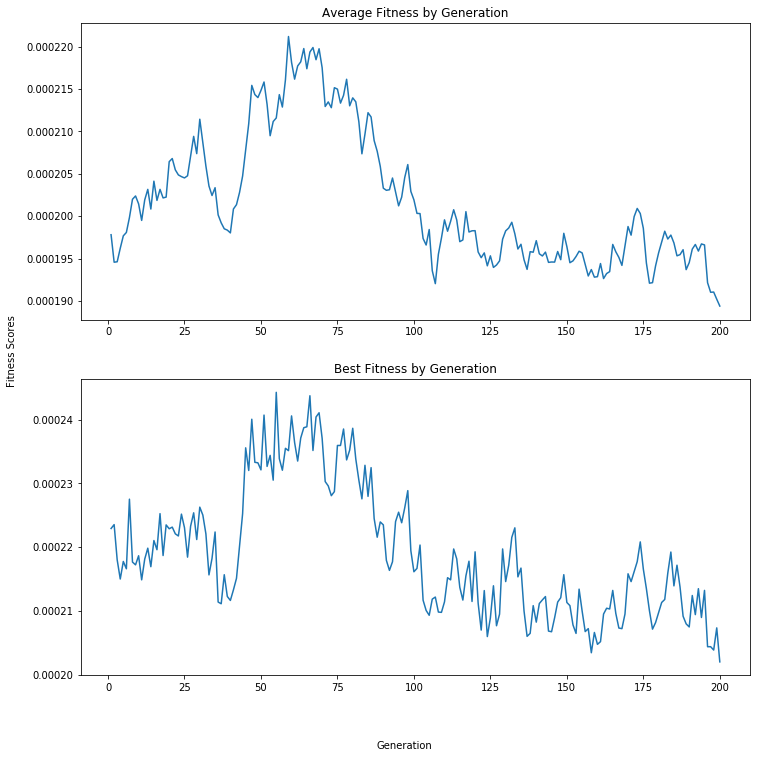

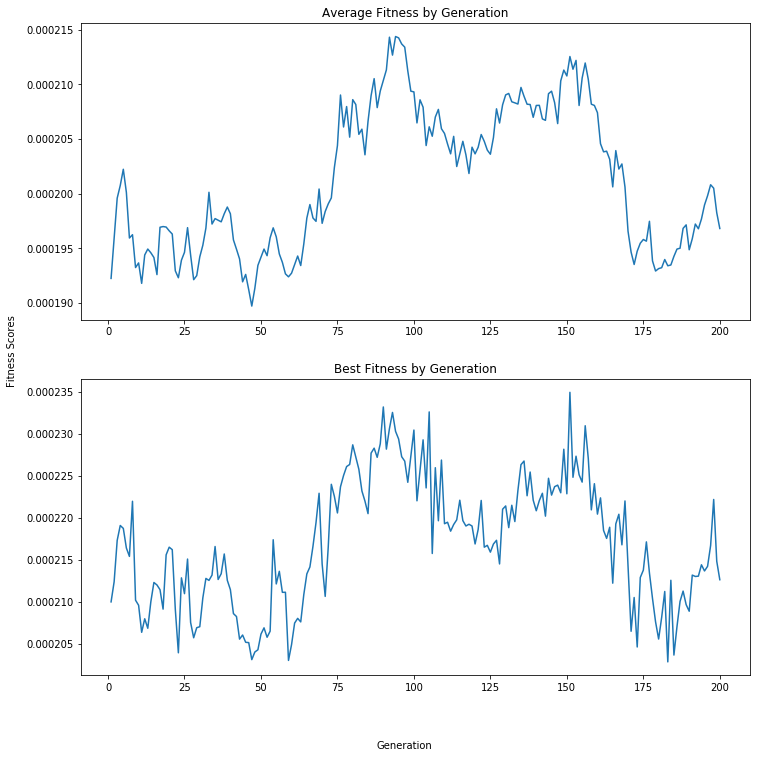

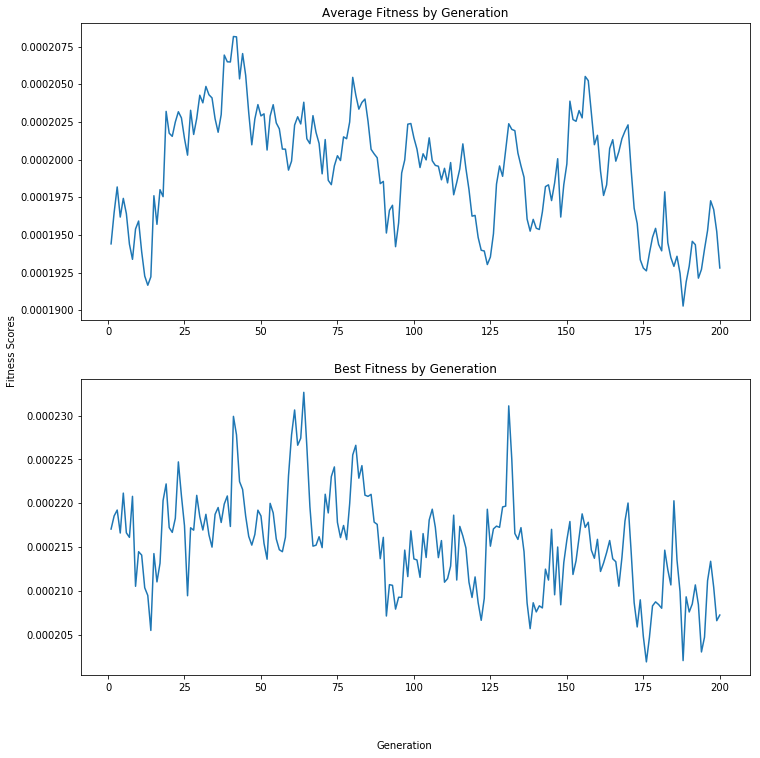

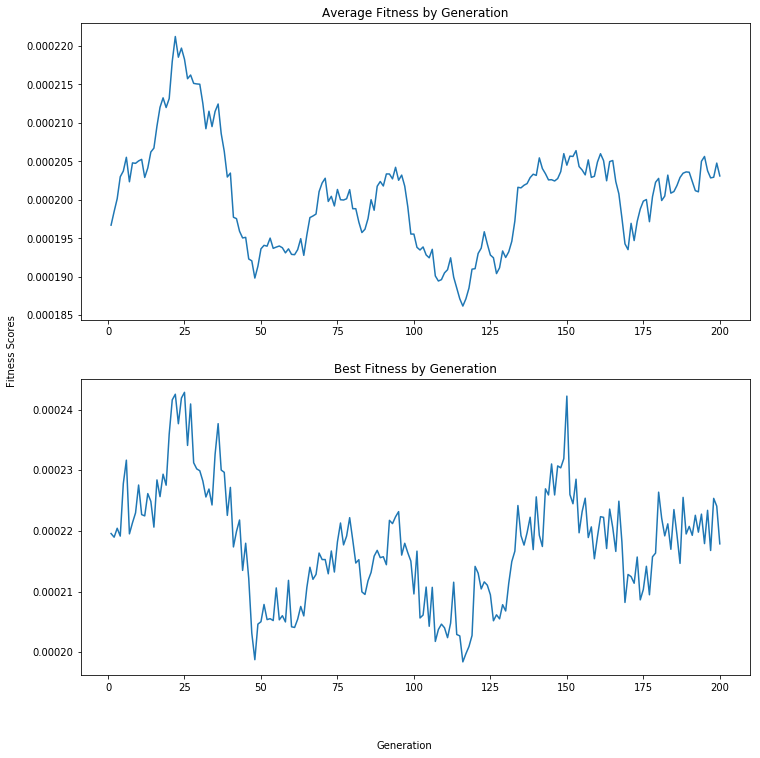

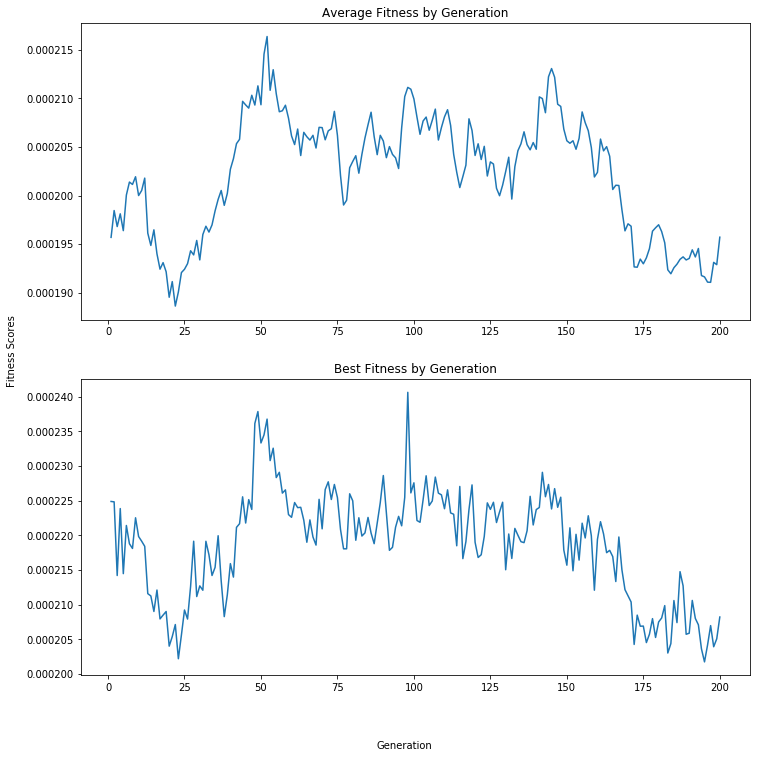

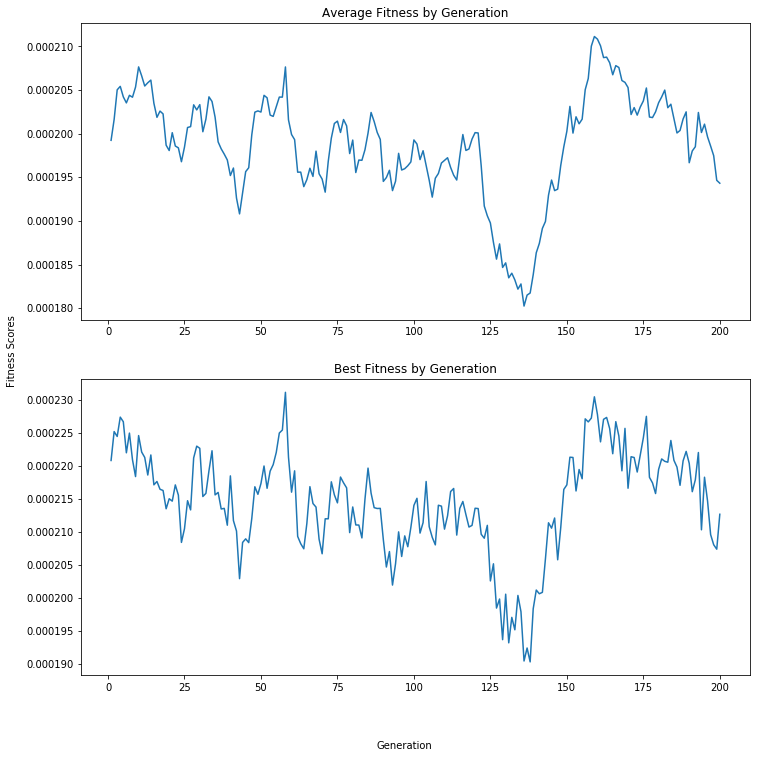

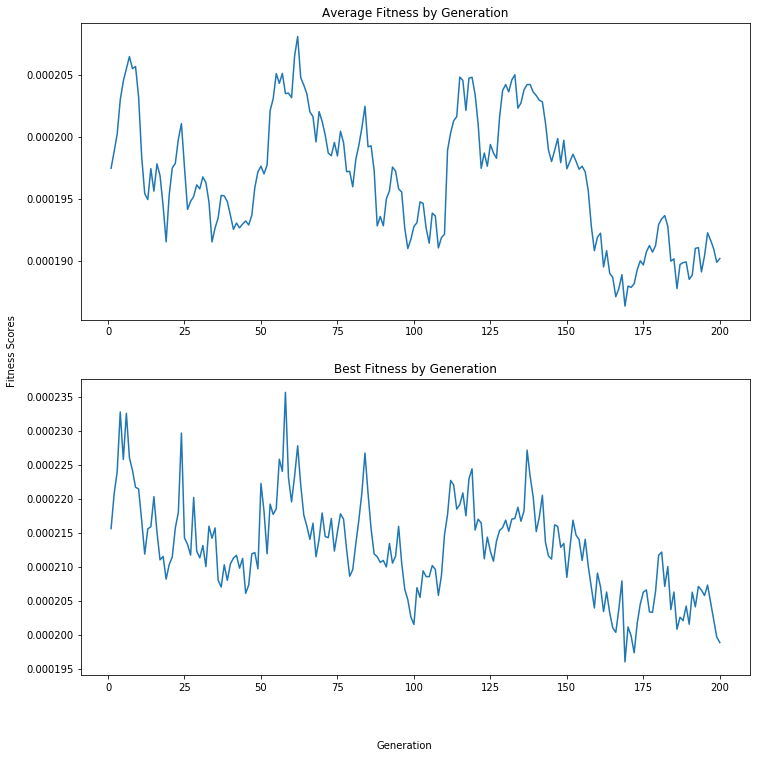

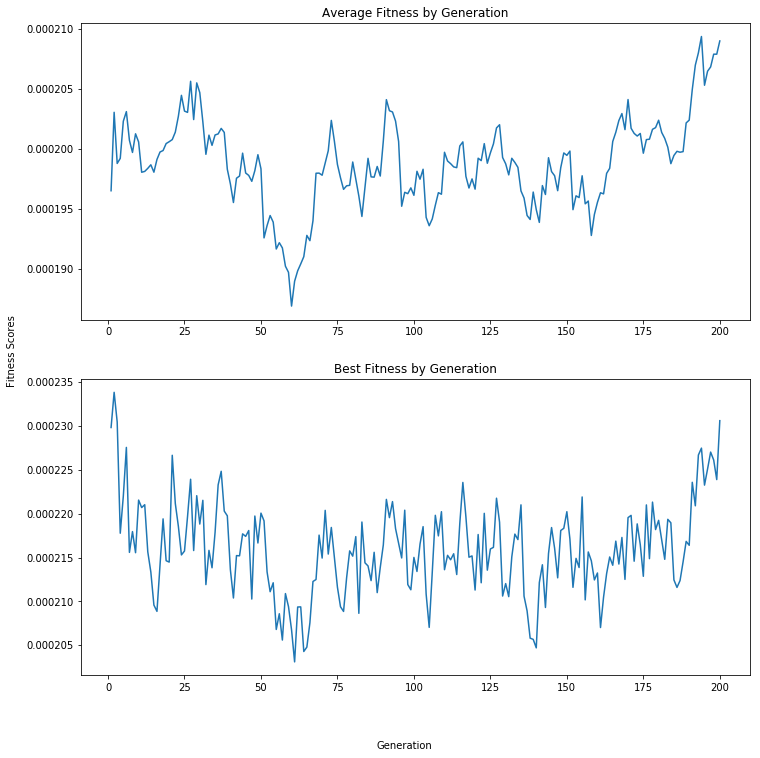

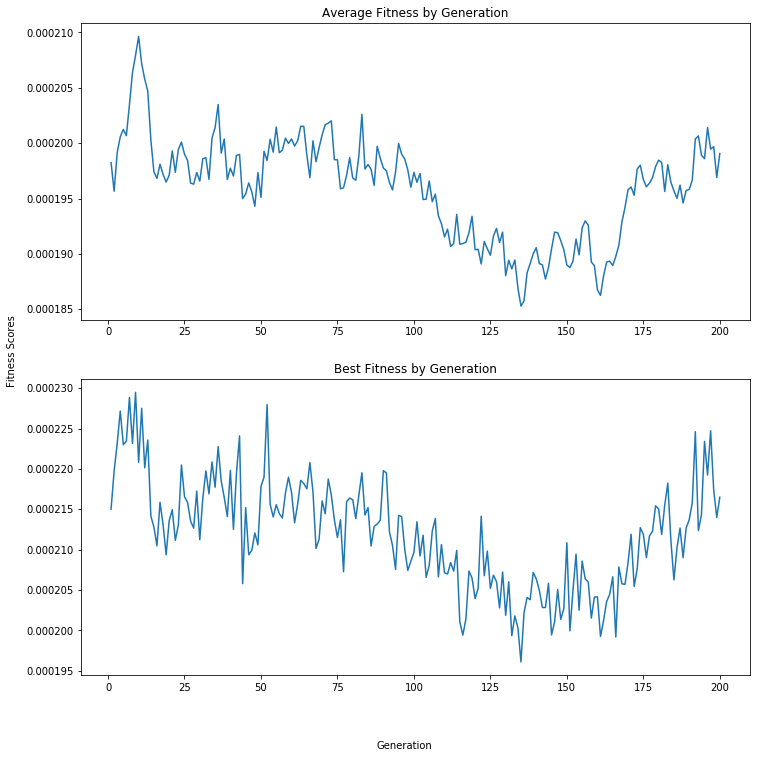

In [5]:
#Read in tsp file
nodes = read_tsp("Random100.tsp")

dists = []
times = []
best_dist = math.inf
best_path = None

#Run ga algorithm 10 times
for i in range(0,10):
    start_time = time.time()
    dist, path = run_ga_tsp(nodes, 200, 0.01, 200, 10, rank_population_proportional)
    run_time = time.time()-start_time
    times.append(run_time)
    dists.append(dist)
    if dist < best_dist:
        best_dist = dist
        best_path = path
        
        
print("Best Path: ")
print(best_path)
print("Distance Statistics: ")
print(stats.describe(dists))
print("Time Statistics: ")
print(stats.describe(times))

# Test 4 - Elevated Mutation Rate

Execution time: 36.14615058898926
Best Overall Fitness: 0.0006440530574470893
Best Path: [77, 26, 62, 44, 57, 82, 58, 80, 67, 27, 9, 42, 5, 78, 65, 88, 22, 52, 45, 96, 100, 86, 23, 21, 41, 74, 24, 7, 83, 90, 29, 51, 20, 60, 6, 81, 15, 72, 79, 40, 98, 25, 84, 33, 4, 87, 35, 31, 59, 64, 13, 56, 97, 8, 70, 94, 71, 89, 85, 75, 66, 19, 39, 99, 16, 93, 17, 37, 38, 3, 36, 95, 68, 10, 92, 1, 43, 73, 30, 53, 91, 63, 28, 61, 32, 55, 46, 34, 12, 69, 54, 18, 47, 11, 49, 48, 2, 76, 14, 50]
Best Overall Distance: 1552.6671109424128
Execution time: 34.51474475860596
Best Overall Fitness: 0.0006078433685983222
Best Path: [89, 36, 38, 37, 66, 21, 3, 39, 41, 53, 19, 23, 86, 17, 74, 94, 83, 85, 72, 30, 92, 71, 24, 1, 79, 20, 60, 98, 40, 13, 33, 84, 29, 56, 87, 76, 45, 52, 100, 50, 77, 5, 31, 6, 25, 81, 68, 95, 73, 43, 15, 10, 90, 54, 51, 69, 11, 88, 78, 42, 58, 9, 14, 62, 80, 82, 22, 96, 49, 46, 67, 27, 64, 44, 57, 26, 35, 59, 8, 97, 4, 47, 18, 12, 70, 16, 34, 48, 2, 65, 61, 32, 63, 28, 91, 55, 99, 93, 7

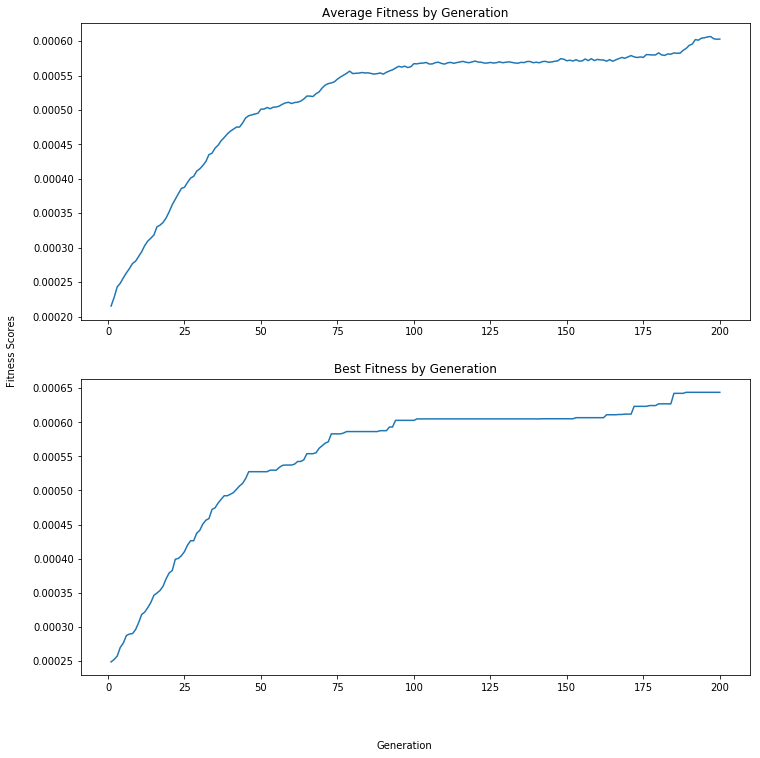

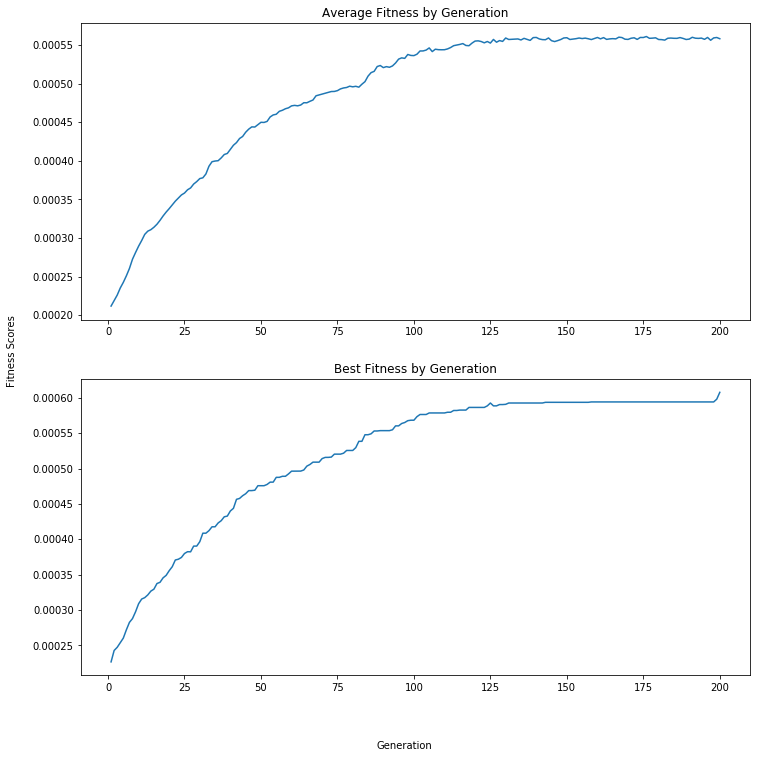

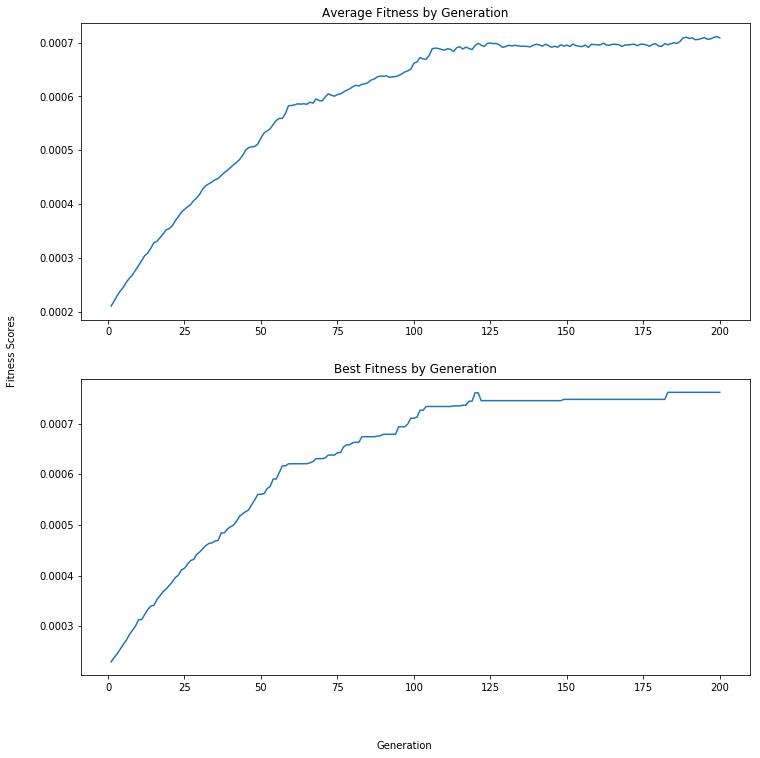

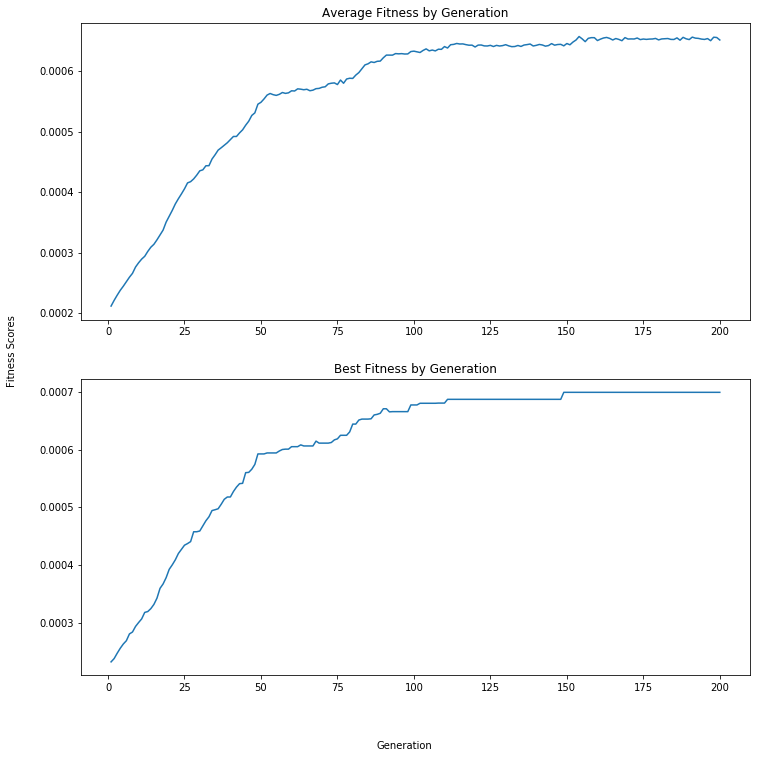

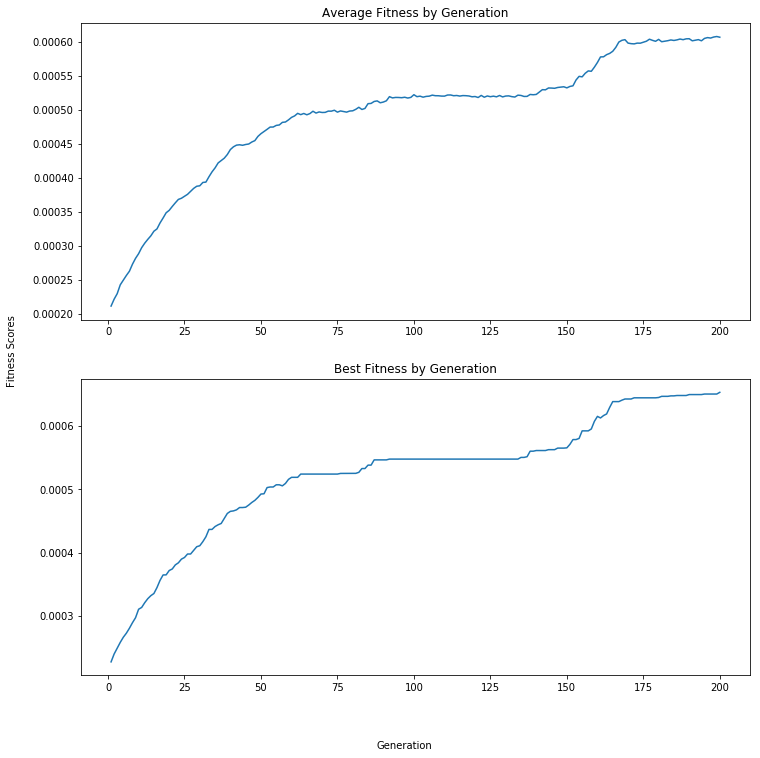

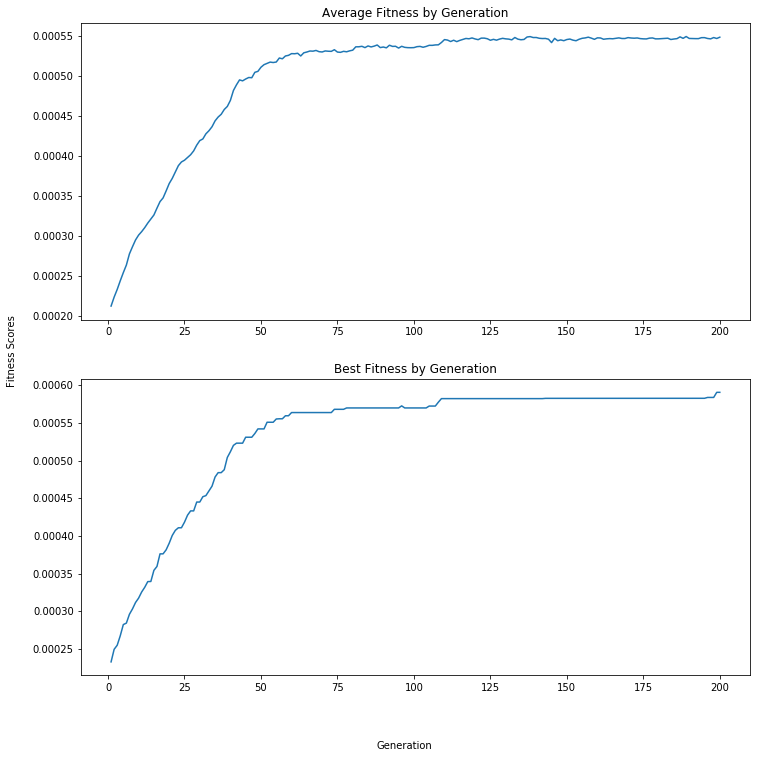

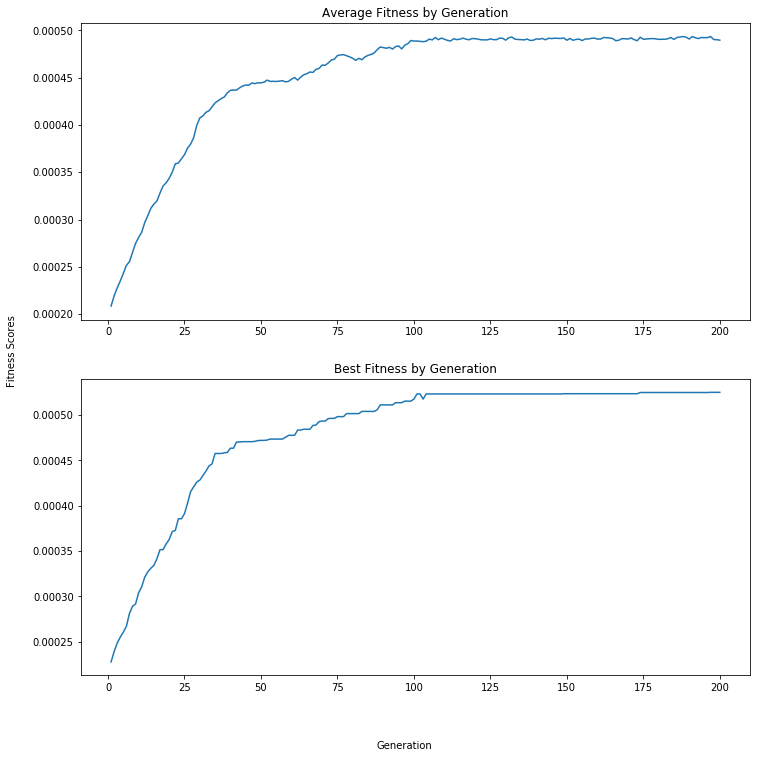

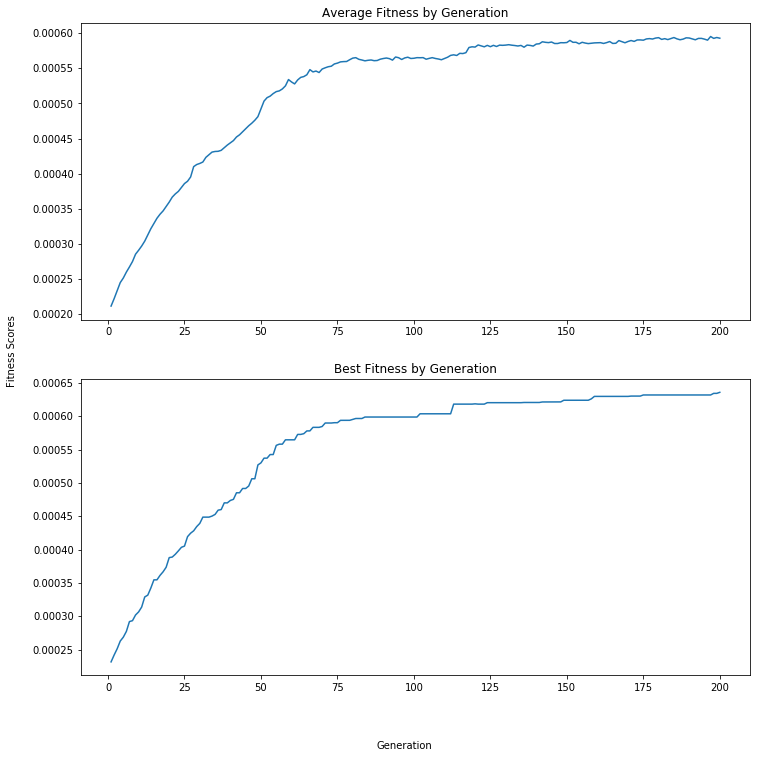

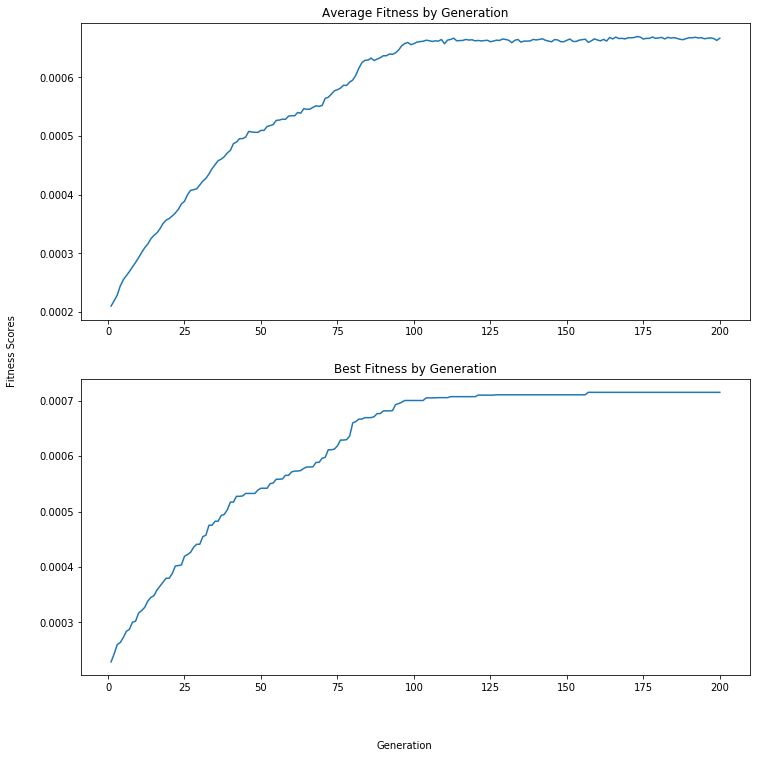

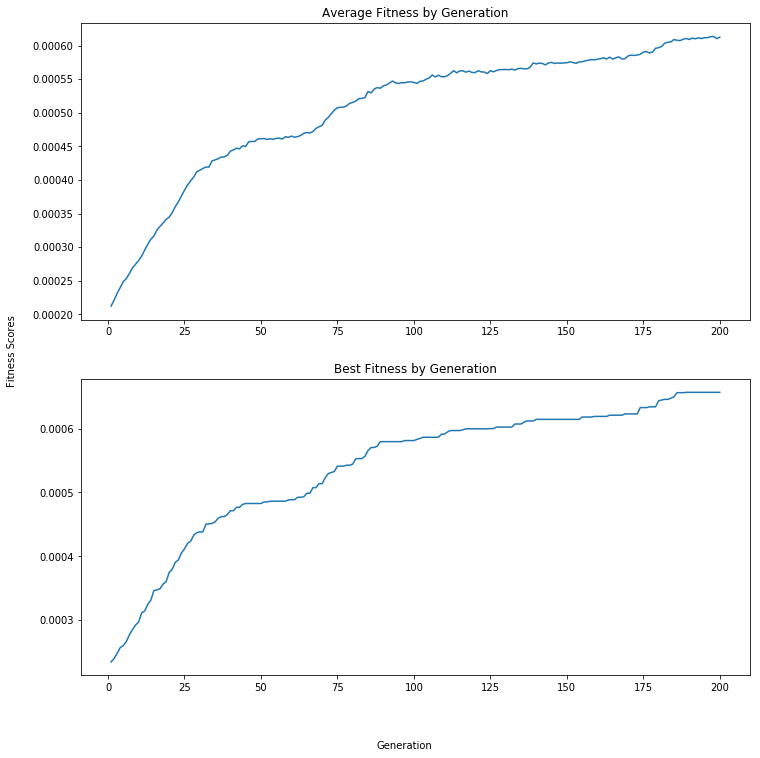

In [6]:
#Read in tsp file
nodes = read_tsp("Random100.tsp")

dists = []
times = []
best_dist = math.inf
best_path = None

#Run ga algorithm 10 times
for i in range(0,10):
    start_time = time.time()
    dist, path = run_ga_tsp(nodes, 200, 0.05, 200, 10, rank_population_elite)
    run_time = time.time()-start_time
    times.append(run_time)
    dists.append(dist)
    if dist < best_dist:
        best_dist = dist
        best_path = path
        
        
print("Best Path: ")
print(best_path)
print("Distance Statistics: ")
print(stats.describe(dists))
print("Time Statistics: ")
print(stats.describe(times))